In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss']
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

reading BED file
Bed File Loaded


In [4]:
# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [5]:
CSV_PATH="/Users/peterpriestley/hmf/analyses/ensembleRuleTesting/"
# SPECIFY SAMPLES
CSV_FILENAMES=[]
for x in os.listdir(CSV_PATH):
    if x[-9:] == ".bam_CNVs":
        CSV_FILENAMES.append(x)

#CSV_FILENAMES = ["CPCT02020357T_dedup.realigned.bam_CNVs"]
#CSV_FILENAMES = CSV_FILENAMES[:10]
len(CSV_FILENAMES)

42

In [6]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[x])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [7]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [8]:
def cnvChart(dfCNV,filename):
    plt.figure(figsize=[18,1])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    #ax.set_yscale('log')
    ax.axis([1, 25, 0, 10])

In [9]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [10]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
        minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

### ANALYSIS

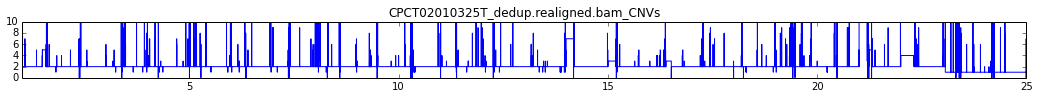

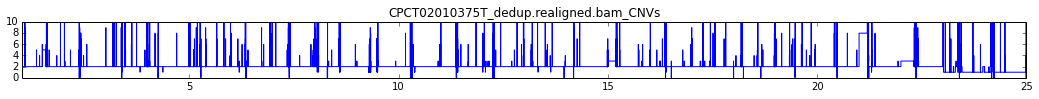

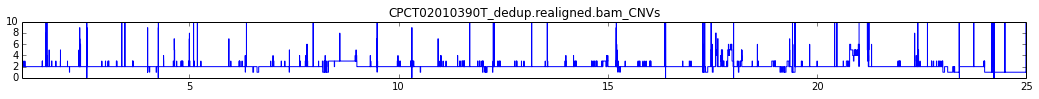

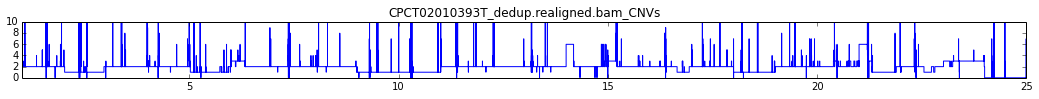

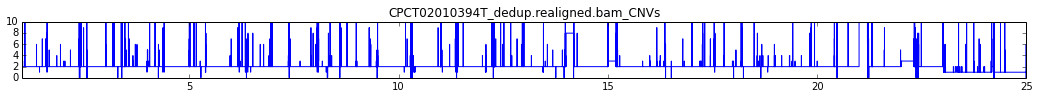

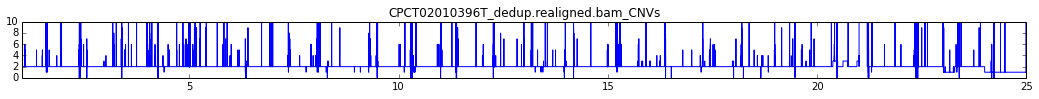

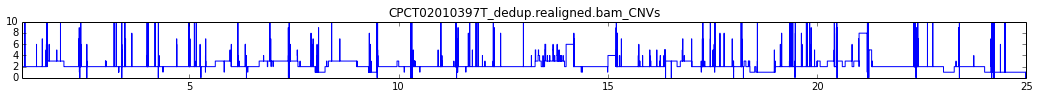

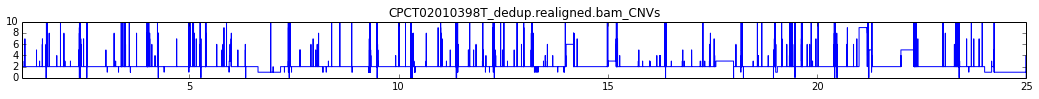

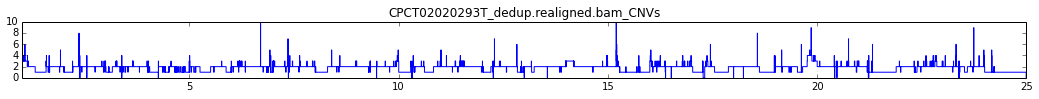

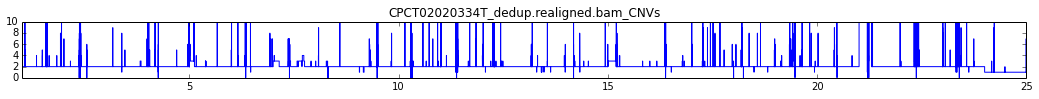

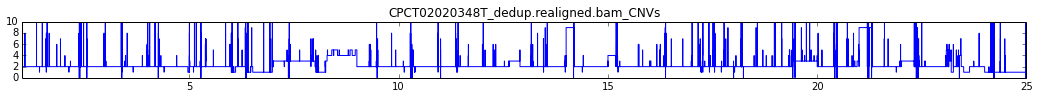

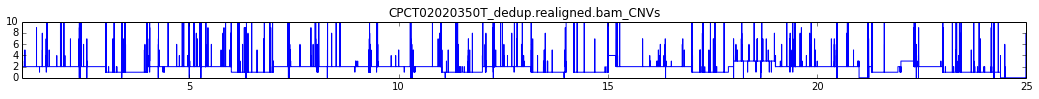

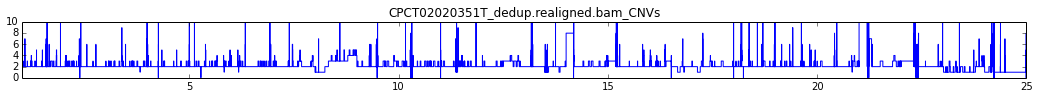

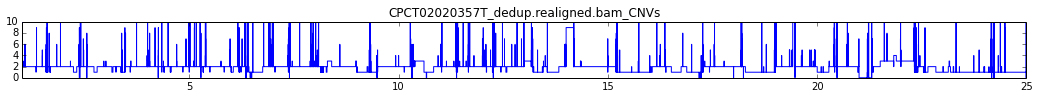

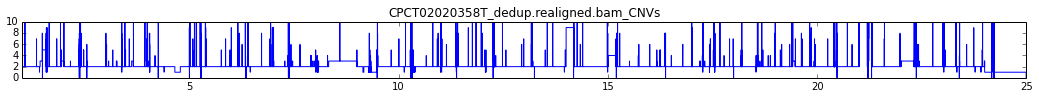

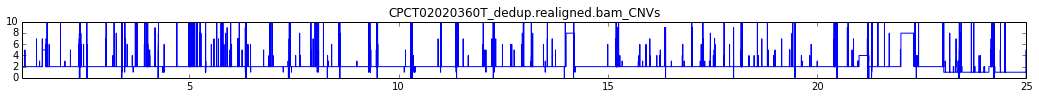

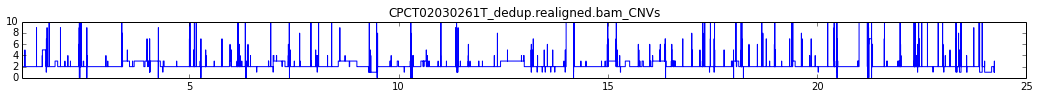

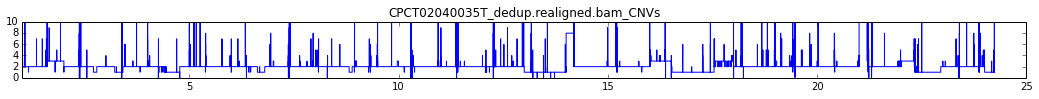

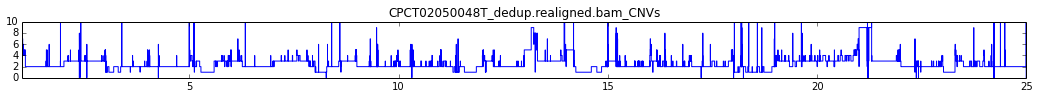

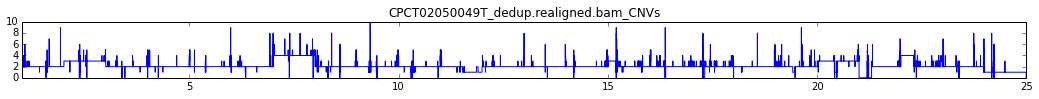

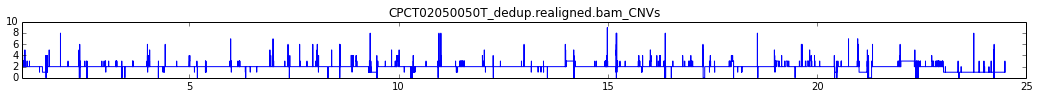

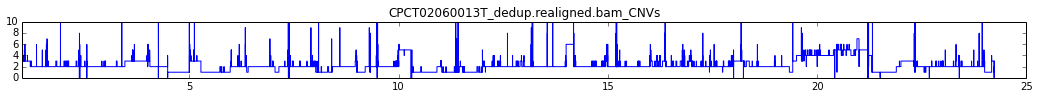

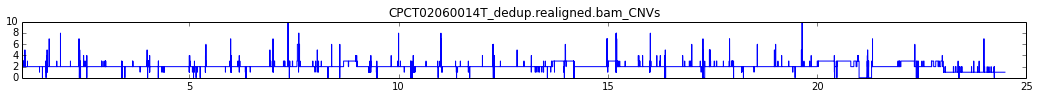

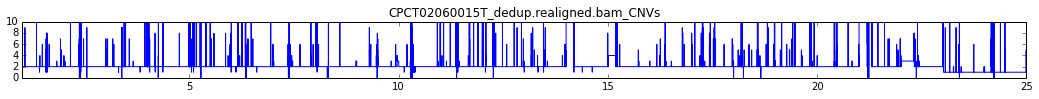

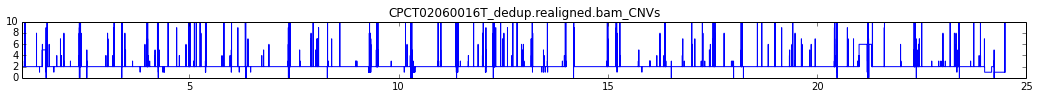

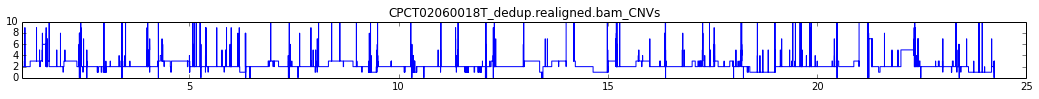

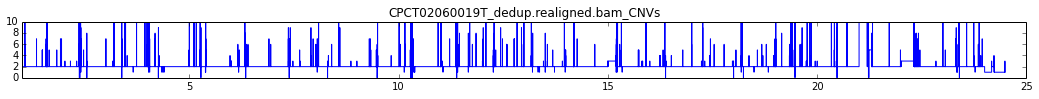

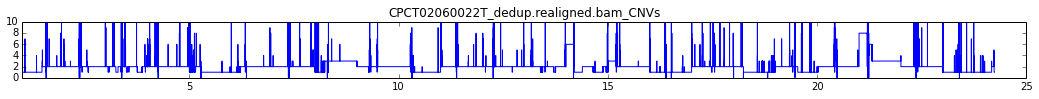

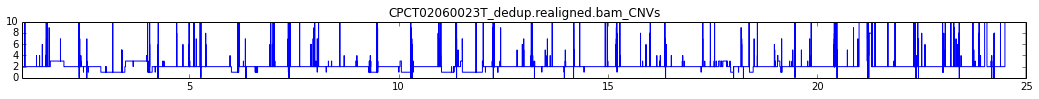

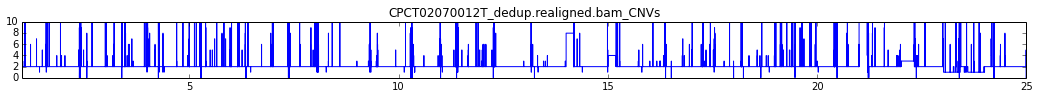

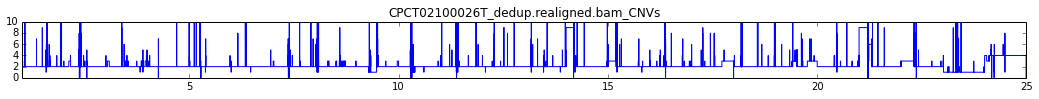

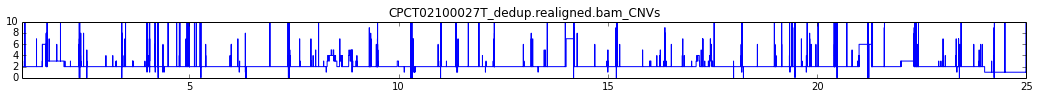

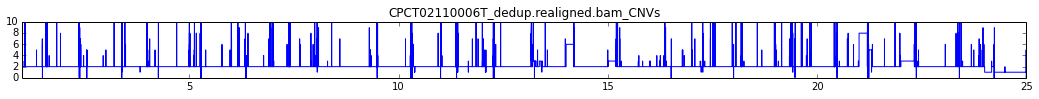

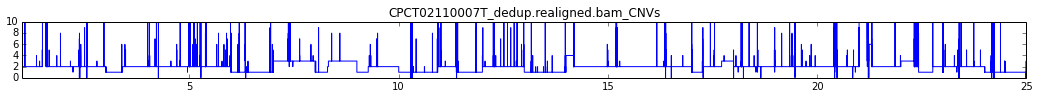

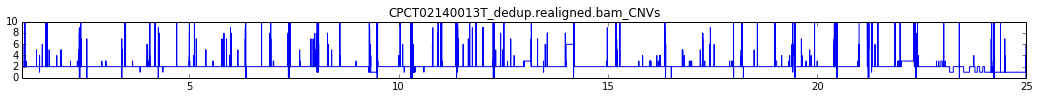

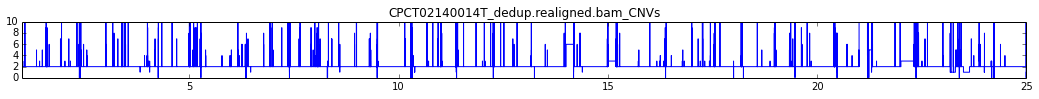

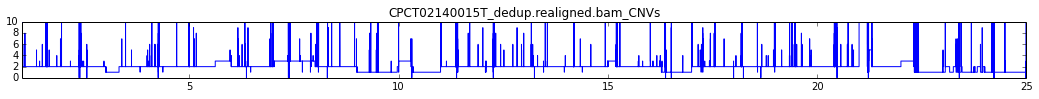

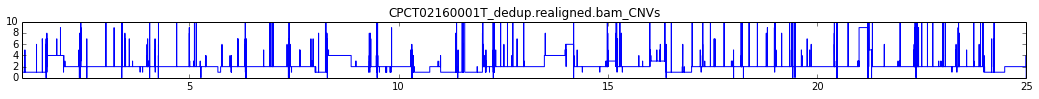

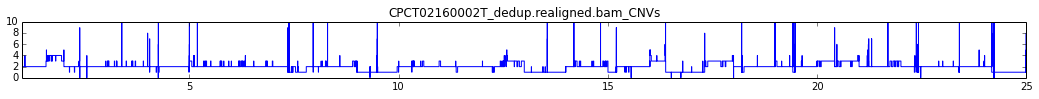

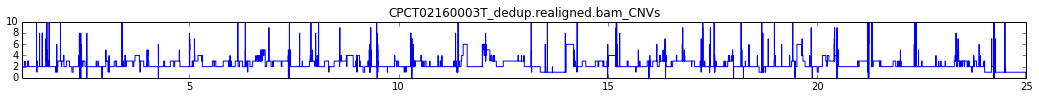

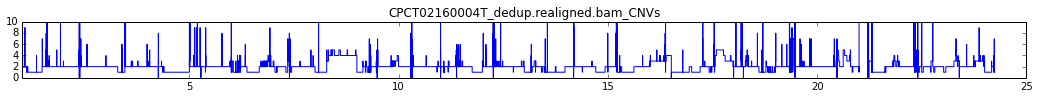

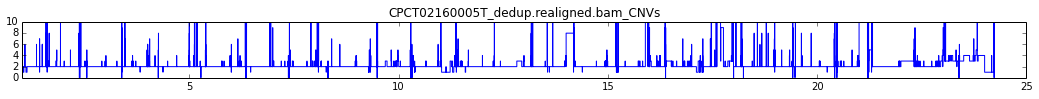

In [17]:
dfAllCNV=pd.DataFrame()
dfAllGeneCNV=pd.DataFrame()
for filename in CSV_FILENAMES:
    patientName=filename[:12]
    dfCNV = loadCNVforPatient(CSV_PATH+filename,patientName)
    dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfCNV,bed,patientName),columns= GENECNV_COLUMNS)
    cnvChart(dfCNV,filename)
    dfAllCNV=pd.concat([dfAllCNV,dfCNV])
    dfAllGeneCNV=pd.concat([dfAllGeneCNV,dfGeneCNV])
dfAllCNV = loadHealthChecksAndMerge(dfAllCNV)
dfAllGeneCNV = loadHealthChecksAndMerge(dfAllGeneCNV)

### LOSS

In [18]:
pd.pivot_table(dfAllGeneCNV[dfAllGeneCNV.cnvLabel=='loss'], values='cnvLabel', index=['gene','chrom'], \
               columns=['TUMOR_TYPE'], aggfunc='count',margins=True).fillna("").\
               sort_values('All',ascending=False)

,TUMOR_TYPE,Breast cancer,Colon and Rectal cancer,Liver cancer,Melanoma,Prostate cancer,Sarcoma,Sarcoma: soft tissue,Skin cancer,Unknown,All
gene,chrom,,,,,,,,,,
All,,92,50,12,53,11,7,19,8,347,599.0
ZRSR2,X,,2,1,1,2,1,2,1,6,16.0
KDM6A,X,1,,1,1,2,1,2,1,7,16.0
AMER1,X,1,,1,,2,1,2,1,7,15.0
STAG2,X,,,1,,1,1,2,1,9,15.0
ATRX,X,,,1,,1,1,2,1,8,14.0
AR,X,1,,1,,,1,2,1,7,13.0
PHF6,X,,,1,,1,1,2,1,7,13.0
KDM5C,X,1,,1,,1,,1,1,5,10.0


### AMPLIFCATION

In [19]:
pd.pivot_table(dfAllGeneCNV[dfAllGeneCNV.minCopyNum>2], values='cnvLabel', index=['gene','chrom'], \
               columns=['TUMOR_TYPE'], aggfunc='count',margins=True).fillna("").sort_values('All',ascending=False)

,TUMOR_TYPE,Breast cancer,Colon and Rectal cancer,Liver cancer,Melanoma,Prostate cancer,Unknown,All
gene,chrom,,,,,,,
All,,218,51,14,104,37,346,770.0
TERT,5,7,1,1,1,,12,22.0
TRAF7,16,5,2,1,1,1,8,18.0
TSC2,16,5,2,1,1,1,8,18.0
FGFR3,4,4,1,1,2,1,8,17.0
NOTCH1,9,4,2,1,1,1,8,17.0
TNFRSF14,1,3,1,1,2,1,8,16.0
UBR5,8,4,1,,1,1,8,15.0
RAD21,8,4,1,,1,1,8,15.0


### BY PATIENT

In [20]:
pd.pivot_table(dfAllCNV, values='regionLength', index=['patientName'], columns=['gainOrLoss'], aggfunc='count').fillna("")

gainOrLoss,gain,loss,none
patientName,,,
CPCT02010325,746,151,596
CPCT02010375,886,131,664
CPCT02010390,430,63,306
CPCT02010393,589,254,375
CPCT02010394,698,111,567
CPCT02010396,715,101,562
CPCT02010397,629,118,406
CPCT02010398,826,83,624
CPCT02020293,293,166,317


In [21]:
pd.pivot_table(dfAllGeneCNV[dfAllGeneCNV.cnvLabel<>'normal'], values='posEnd', index=['patientName'], columns=['cnvLabel'], aggfunc='count').fillna("")

cnvLabel,amplification,loss
patientName,,
CPCT02010325,,12
CPCT02010375,,7
CPCT02010390,30,11
CPCT02010393,21,39
CPCT02010394,,7
CPCT02010396,1,1
CPCT02010397,22,4
CPCT02010398,7,5
CPCT02020293,26,45


### CDF of Gain / Loss

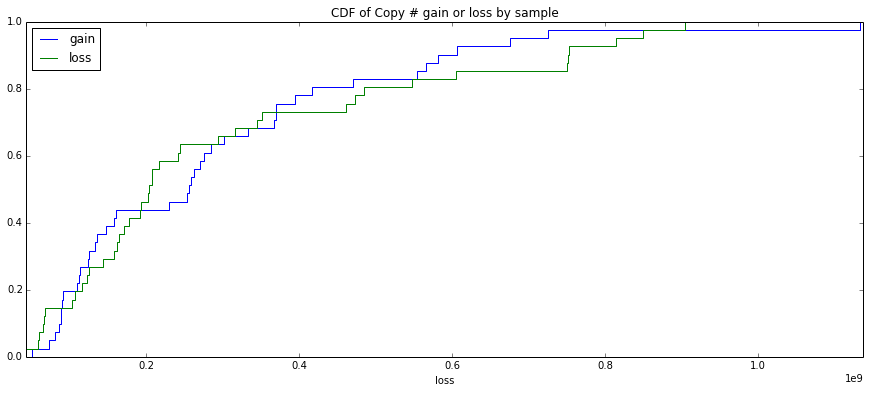

In [22]:
dfGainOrLoss = pd.pivot_table(dfAllCNV[dfAllCNV.gainOrLoss<>'none'], values='regionLength', index=['patientName'], columns=['gainOrLoss'], aggfunc='sum').fillna("")
#Alllele Freq By Caller
for columnName in ['gain','loss']:
    ser = dfGainOrLoss[columnName]
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=columnName)
    ser_cdf.plot(drawstyle='steps',legend=True,title="CDF of Copy # gain or loss by sample",figsize=[15,6])

In [23]:
dfGainOrLoss

gainOrLoss,gain,loss
patientName,,
CPCT02010325,125045000,202305566
CPCT02010375,86506668,194184566
CPCT02010390,270593231,162135566
CPCT02010393,302562796,849309456
CPCT02010394,90987029,203501566
CPCT02010396,50650520,103882566
CPCT02010397,675374388,207436814
CPCT02010398,133670753,158427566
CPCT02020293,147535414,814704828
